In [1]:
%load_ext autoreload
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict
import seaborn as sns
from io import StringIO
import scipy

pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_columns', None)

cmap = sns.diverging_palette(220, 10, as_cmap=True)
from IPython.core.display import Image

from perturbseq_v3 import *
from sklearn.linear_model import LinearRegression, TheilSenRegressor

In [2]:
# Set up plotting settings
almost_black = '#262626'

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 14
plt.rcParams['font.weight'] = 'light'
plt.rcParams['text.color'] = almost_black

axisLineWidth = .5
plt.rcParams['axes.linewidth'] = axisLineWidth
plt.rcParams['lines.linewidth'] = 1.5

plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.handletextpad'] = .25
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['ytick.color'] = almost_black
plt.rcParams['ytick.major.width'] = axisLineWidth
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['xtick.color'] = almost_black
plt.rcParams['xtick.major.width'] = axisLineWidth

def plotGrid(axis, vert_origin = True, horiz_origin=True, unity=True):
    ylim = axis.get_ylim()
    xlim = axis.get_xlim()
    if vert_origin:
        axis.plot((0,0), ylim, color='#BFBFBF', lw=.5, alpha=.5) 
    if horiz_origin:
        axis.plot(xlim,(0,0), color='#BFBFBF', lw=.5, alpha=.5) 
    if unity:
        xmin = min(xlim[0], ylim[0])
        xmax = max(xlim[1], ylim[1])
        axis.plot((xmin,xmax),(xmin,xmax), color='#BFBFBF', lw=.5, alpha=.5) 
        axis.plot((xmin,xmax),(-xmin,-xmax), color='#BFBFBF', lw=.5, alpha=.5) 

    axis.set_ylim(ylim)
    axis.set_xlim(xlim)

## Loading the data

In [3]:
# Load the cell population using methods from: https://github.com/thomasmaxwellnorman/perturbseq_demo

pop = CellPopulation.from_file('perturbseq_data/',
                               genome='GRCh38', version='v3', direct_capture=False)

Loading digital expression data: perturbseq_data/outs/filtered_feature_bc_matrix/matrix.mtx.gz...
Densifying matrix...
Loading guide identities:perturbseq_data/outs/cell_identities.csv...
Generating summary statistics...
Done.


In [4]:
# Select the single cells
pop = pop.subpopulation(cells='single_cell')

Generating summary statistics...
Done.


In [5]:
print pop.matrix.shape

(29476, 33694)


In [6]:
cell_counts = pd.DataFrame()
for n in range(1, 9):
    cell_counts = pd.concat([cell_counts, pop.cells.query('gemgroup == @n')["guide_identity"].value_counts().to_frame().rename(columns={'guide_identity':n})], axis=1)

In [7]:
# Load the sgRNA tables

sgRNA_table_crispri_ave = pd.read_csv('perturbseq_crispri_sgRNA_table.txt', sep='\t', index_col = 0)
sgRNA_table_crispra_ave = pd.read_csv('perturbseq_crispra_sgRNA_table.txt', sep='\t', index_col = 0)

In [8]:
sgRNA_table_crispri_ave.index = sgRNA_table_crispri_ave["gene"] + '_' + sgRNA_table_crispri_ave.index
sgRNA_table_crispra_ave.index = sgRNA_table_crispra_ave["gene"] + '_' + sgRNA_table_crispra_ave.index

In [9]:
for n in range(1, 7):
    sgRNA_table_crispri_ave['cell_count_'+str(n)] = pop.cells.query('gemgroup == @n')["guide_identity"].value_counts() #.to_frame().rename(columns={'guide_identity':'count_count_'+str(n)})
for n in range(7, 9):
    sgRNA_table_crispra_ave['cell_count_'+str(n)] = pop.cells.query('gemgroup == @n')["guide_identity"].value_counts() #.to_frame().rename(columns={'guide_identity':'count_count_'+str(n)})

In [10]:
perturbation_renamer = {1: 'crispri', 2: 'crispri', 3: 'crispri', 4: 'crispri', 5: 'crispri', 6: 'crispri', 7: 'crispra', 8:'crispra'}

treatment_renamer = {1: 'no', 2: 'no', 3: 'no', 4: 'cisplatin', 5: 'cisplatin', 6: 'cisplatin', 7: 'no', 8:'cisplatin'}

treatment = pop.cells['gem_group'].map(lambda x: treatment_renamer[x])
treatment.name = 'treatment'
perturbation = pop.cells['gem_group'].map(lambda x: perturbation_renamer[x])
perturbation.name = 'perturbation'

In [11]:
pop.add_property(cells=pd.DataFrame([treatment, perturbation]).T)

In [12]:
long_experiment = pop.cells['guide_target'] + '_' + treatment
long_experiment.name = 'long_experiment'

In [13]:
pop.add_property(cells=pd.DataFrame([long_experiment]).T)

In [14]:
pop.cells.head()

,UMI_count,gem_group,gemgroup,good_coverage,guide_UMI_count,guide_coverage,guide_identity,guide_read_count,guide_target,number_of_cells,perturbation,single_cell,treatment,long_experiment
cell_barcode,,,,,,,,,,,,,,
AAACCCAGTAGTCGTT-1,18291,1,1.0000,True,15.0000,59.1333,MED12_MED12_+_70338478.23-P1P2,887.0000,MED12,1.0000,crispri,True,no,MED12_no
AAACGAACAATTGTGC-1,21014,1,1.0000,True,228.0000,108.9518,ZKSCAN2_ZKSCAN2_-_25268864.23-P1P2,24841.0000,ZKSCAN2,1.0000,crispri,True,no,ZKSCAN2_no
AAACGCTCACAATGTC-1,21081,1,1.0000,True,169.0000,72.7101,HMGN2_HMGN2_+_26799363.23-P1P2,12288.0000,HMGN2,1.0000,crispri,True,no,HMGN2_no
AAAGAACAGGTAGACC-1,16687,1,1.0000,True,74.0000,72.1351,MED16_MED16_+_893158.23-P1P2,5338.0000,MED16,1.0000,crispri,True,no,MED16_no
AAAGAACCACTGCATA-1,11190,1,1.0000,True,111.0000,81.1441,DNMT1_DNMT1_-_10305600.23-P1P2,9007.0000,DNMT1,1.0000,crispri,True,no,DNMT1_no


In [15]:
pop.genes.head()

,gene_name,feature_type,mean,std,cv,fano,in_matrix
gene_id,,,,,,,
ENSG00000243485,RP11-34P13.3,Gene Expression,0.0001,0.0082,121.3981,1.0000,True
ENSG00000237613,FAM138A,Gene Expression,0.0000,0.0000,nan,nan,True
ENSG00000186092,OR4F5,Gene Expression,0.0000,0.0000,nan,nan,True
ENSG00000238009,RP11-34P13.7,Gene Expression,0.0032,0.0564,17.6801,0.9968,True
ENSG00000239945,RP11-34P13.8,Gene Expression,0.0001,0.0082,121.3981,1.0000,True


In [16]:
pop_i = pop.subpopulation(cells='perturbation == "crispri"')
pop_a = pop.subpopulation(cells='perturbation == "crispra"')

Generating summary statistics...
Done.
Generating summary statistics...
Done.


In [17]:
pop_i.normalized_matrix = normalize_to_control(pop_i, control_cells='guide_target == "negative" and treatment == "no"')
pop_a.normalized_matrix = normalize_to_control(pop_a, control_cells='guide_target == "negative" and treatment == "no"')

     Determining scale factors...
     Normalizing matrix to median
     Normalizing control matrix to median
     Scaling matrix to control
     Done.
     Determining scale factors...
     Normalizing matrix to median
     Normalizing control matrix to median
     Scaling matrix to control
     Done.


In [18]:
control_pop_i = pop_i.subpopulation(cells='guide_target == "negative" and treatment == "no"', normalized_matrix='inherit')
control_pop_a = pop_a.subpopulation(cells='guide_target == "negative" and treatment == "no"', normalized_matrix='inherit')

Generating summary statistics...
Done.
Inheriting from parent normalized matrix...
Generating summary statistics...
Done.
Inheriting from parent normalized matrix...


In [19]:
# Add cell cycle scores (from https://github.com/thomasmaxwellnorman/perturbseq_demo)

cell_cycle_genes = get_cell_phase_genes(control_pop_i, refine=True, threshold=0.3)
add_cell_cycle_scores(pop_i, gene_list=cell_cycle_genes)
add_cell_cycle_scores(control_pop_i, gene_list=cell_cycle_genes)

cell_cycle_genes = get_cell_phase_genes(control_pop_a, refine=True, threshold=0.3)
add_cell_cycle_scores(pop_a, gene_list=cell_cycle_genes)
add_cell_cycle_scores(control_pop_a, gene_list=cell_cycle_genes)


perturbseq_v3/cell_cycle.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  expression_matrix['total'] = expression_matrix.mean(axis=1)


In [20]:
# Calculate average expression profiles
mean_pop_i = pop_i.average('long_experiment')

Computing average expression matrices...
Computing normalized average expression matrices...
Computing clusters...
Generating summary statistics...
Done.


In [21]:
mean_pop_a = pop_a.average('long_experiment')

Computing average expression matrices...
Computing normalized average expression matrices...
Computing clusters...
Generating summary statistics...
Done.


## Epistasis modeling

In [22]:
# Following https://github.com/thomasmaxwellnorman/Perturbseq_GI

mean_pop_i_temp = pop_i.average('long_experiment')
pop_i_temp = pop.subpopulation(cells='perturbation == "crispri"')

Computing average expression matrices...
Computing normalized average expression matrices...
Computing clusters...
Generating summary statistics...
Done.
Generating summary statistics...
Done.


In [23]:
mean_pop_i_temp.cells['guide_target'] = mean_pop_i_temp.cells.index
mean_pop_i_temp.cells['num_targets'] = 2 - mean_pop_i_temp.cells.index.str.count('negative_') - mean_pop_i_temp.cells.index.str.count('_no')

In [24]:
pop_i_temp.cells.head()

,UMI_count,gem_group,gemgroup,good_coverage,guide_UMI_count,guide_coverage,guide_identity,guide_read_count,guide_target,number_of_cells,perturbation,single_cell,treatment,long_experiment
cell_barcode,,,,,,,,,,,,,,
AAACCCAGTAGTCGTT-1,18291,1,1.0000,True,15.0000,59.1333,MED12_MED12_+_70338478.23-P1P2,887.0000,MED12,1.0000,crispri,True,no,MED12_no
AAACGAACAATTGTGC-1,21014,1,1.0000,True,228.0000,108.9518,ZKSCAN2_ZKSCAN2_-_25268864.23-P1P2,24841.0000,ZKSCAN2,1.0000,crispri,True,no,ZKSCAN2_no
AAACGCTCACAATGTC-1,21081,1,1.0000,True,169.0000,72.7101,HMGN2_HMGN2_+_26799363.23-P1P2,12288.0000,HMGN2,1.0000,crispri,True,no,HMGN2_no
AAAGAACAGGTAGACC-1,16687,1,1.0000,True,74.0000,72.1351,MED16_MED16_+_893158.23-P1P2,5338.0000,MED16,1.0000,crispri,True,no,MED16_no
AAAGAACCACTGCATA-1,11190,1,1.0000,True,111.0000,81.1441,DNMT1_DNMT1_-_10305600.23-P1P2,9007.0000,DNMT1,1.0000,crispri,True,no,DNMT1_no


In [25]:
res = mean_pop_i_temp.cells.index.to_series().str.rsplit("_", expand = True, n=1)
res.columns = ['first_target', 'second_target']

res['num_targets'] = [1] * res.shape[0]
res['num_targets'][np.logical_and(res['first_target'] != 'negative', res['second_target'] != 'no')] = 2
res['num_targets'][np.logical_and(res['first_target'] == 'negative', res['second_target'] == 'no')] = 'controls'

/home/jchen/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/jchen/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [26]:
res.head()

,first_target,second_target,num_targets
ARID5B_cisplatin,ARID5B,cisplatin,2
ARID5B_no,ARID5B,no,1
BOD1L1_cisplatin,BOD1L1,cisplatin,2
BOD1L1_no,BOD1L1,no,1
BRCA1_cisplatin,BRCA1,cisplatin,2


In [27]:
mean_pop_i_temp.add_property(cells=res['first_target'], name='first_target')
mean_pop_i_temp.add_property(cells=res['second_target'], name='second_target')
mean_pop_i_temp.add_property(cells=res['num_targets'], name='num_targets')

In [28]:
perturbations = list(mean_pop_i_temp.cells.index)
perturbation_ids = pop_i_temp.gene_ids(np.union1d(mean_pop_i_temp.cells['first_target'], mean_pop_i_temp.cells['second_target']))
abundant_genes = np.setdiff1d(pop_i_temp.genes.query('mean > 0.5').index.values, perturbation_ids)

In [29]:
# Calculate differentially expressed genes using KS test
ks, ps, adj_ps = ks_de(pop_i,
                   key='long_experiment',
                   control_cells='long_experiment == "negative_no"',
                   genes='mean > 0.25',
                   normalized=True,
                   alpha=0.05,
                   multi_method='fdr_by',
                   n_jobs=16)

549 control cells
groupby: index in @key_barcodes (key = long_experiment)


[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    4.3s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    6.2s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    7.5s
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    9.6s
[Parallel(n_jobs=16)]: Done  53 tasks      | elapsed:   12.1s
[Parallel(n_jobs=16)]: Done  66 tasks      | elapsed:   13.9s
[Parallel(n_jobs=16)]: Done  81 tasks      | elapsed:   16.6s
[Parallel(n_jobs=16)]: Done  96 tasks      | elapsed:   19.6s
[Parallel(n_jobs=16)]: Done 117 out of 134 | elapsed:   23.1s remaining:    3.4s
[Parallel(n_jobs=16)]: Done 131 out of 134 | elapsed:   25.6s remaining:    0.6s
[Parallel(n_jobs=16)]: Done 134 out of 134 | elapsed:   26.2s finished


In [30]:
doubles = list()

for idx, row in mean_pop_i_temp.cells.loc[perturbations].query('num_targets == 2').iterrows():
    first = row['first_target'] + '_no'
    second = 'negative_' + row['second_target']
    if (first in mean_pop_i_temp.cells.index) and (second in mean_pop_i_temp.cells.index):
        doubles.append((first, second, idx))

gene_lists = [(first, second, double, abundant_genes) for first, second, double in doubles
               if ((adj_ps[double] < 0.05).sum() > 10)]

In [31]:
matrix = mean_pop_i_temp.normalized_matrix.copy()

In [32]:
def get_model(first, second, double, variable_genes, matrix):
    out = dict()
    
    singles_expr = matrix.loc[[first, second], variable_genes].T.values
    first_expr = matrix.loc[first, variable_genes].values.reshape(-1, 1)
    second_expr = matrix.loc[second, variable_genes].values.reshape(-1, 1)
    double_expr = matrix.loc[double, variable_genes].values.reshape(-1, 1)
    
    ts = TheilSenRegressor(fit_intercept=False,
                          max_subpopulation=1e5,
                          max_iter=1000,
                          random_state=1000)
    
    X = singles_expr
    y = double_expr
    ts.fit(X, y.ravel())
    
    return ts

def get_model_predictions(first, second, double, variable_genes):
    out = dict()
    
    singles_expr = matrix.loc[[first, second], variable_genes].T.values
    first_expr = matrix.loc[first, variable_genes].values.reshape(-1, 1)
    second_expr = matrix.loc[second, variable_genes].values.reshape(-1, 1)
    double_expr = matrix.loc[double, variable_genes].values.reshape(-1, 1)
    
    regr = LinearRegression(fit_intercept=False)
    ts = TheilSenRegressor(fit_intercept=False,
                          max_subpopulation=1e5,
                          max_iter=1000,
                          random_state=1000)    
    X = singles_expr
    y = double_expr
    regr.fit(X, y)
    ts.fit(X, y.ravel())
    Z = regr.predict(X)
    Zts = ts.predict(X)
    
    out['name'] = double
    out['pred'] = pd.Series(Z.flatten(), index=variable_genes, name=double)
    out['ts_pred'] = pd.Series(Zts.flatten(), index=variable_genes, name=double)
    out['first_expr'] = pd.Series(first_expr.flatten(), index=variable_genes, name=double)
    out['second_expr'] = pd.Series(second_expr.flatten(), index=variable_genes, name=double)
    out['double_expr'] = pd.Series(double_expr.flatten(), index=variable_genes, name=double)

    return out

In [33]:
from joblib import Parallel, delayed

pred_data = Parallel(n_jobs=24, verbose=10)(delayed(get_model_predictions)(*double) for double in gene_lists)


[Parallel(n_jobs=24)]: Done   3 out of  34 | elapsed:   14.6s remaining:  2.5min
[Parallel(n_jobs=24)]: Done   7 out of  34 | elapsed:   14.8s remaining:   56.9s
[Parallel(n_jobs=24)]: Done  11 out of  34 | elapsed:   14.9s remaining:   31.1s
[Parallel(n_jobs=24)]: Done  15 out of  34 | elapsed:   15.0s remaining:   19.0s
[Parallel(n_jobs=24)]: Done  19 out of  34 | elapsed:   15.2s remaining:   12.0s
[Parallel(n_jobs=24)]: Done  23 out of  34 | elapsed:   15.6s remaining:    7.4s
[Parallel(n_jobs=24)]: Done  27 out of  34 | elapsed:   26.5s remaining:    6.9s
[Parallel(n_jobs=24)]: Done  31 out of  34 | elapsed:   26.9s remaining:    2.6s
[Parallel(n_jobs=24)]: Done  34 out of  34 | elapsed:   27.1s finished


In [34]:
preds = pd.DataFrame([pred['pred'] for pred in pred_data])
ts_preds = pd.DataFrame([pred['ts_pred'] for pred in pred_data])
first_exprs = pd.DataFrame([pred['first_expr'] for pred in pred_data])
second_exprs = pd.DataFrame([pred['second_expr'] for pred in pred_data])
double_exprs = pd.DataFrame([pred['double_expr'] for pred in pred_data])

In [35]:
mean_pop = mean_pop_i_temp

In [36]:
control_pop = pop_i.subpopulation(cells='guide_target == "negative" and treatment == "no"', normalized_matrix='inherit')

Generating summary statistics...
Done.
Inheriting from parent normalized matrix...


In [37]:
# Epistasis model with both simple additive model and linear model

In [38]:
%%capture

gene = "ERCC4"
subpop = pop_i.subpopulation(cells='guide_target == "%s" | guide_target == "negative"' %(gene), normalized_matrix='inherit')
res = tree_selector(subpop,
                    key='long_experiment',
                    num_features=100,
                    genes='mean > 0.25',
                    normalized=True,
                    n_jobs=16)
tree_genes = res.selected_genes
mean_subpop = subpop.average('long_experiment')

mean_subpop_tree = mean_subpop.normalized_matrix.loc[:, tree_genes]

new_row = mean_subpop_tree.loc["negative_cisplatin"] + mean_subpop_tree.loc[gene+'_no']
new_row.name = 'additive model'
mean_subpop_tree = pd.concat([pd.DataFrame(new_row).T, mean_subpop_tree])

mean_subpop_tree.columns = subpop.gene_names(mean_subpop_tree.columns)

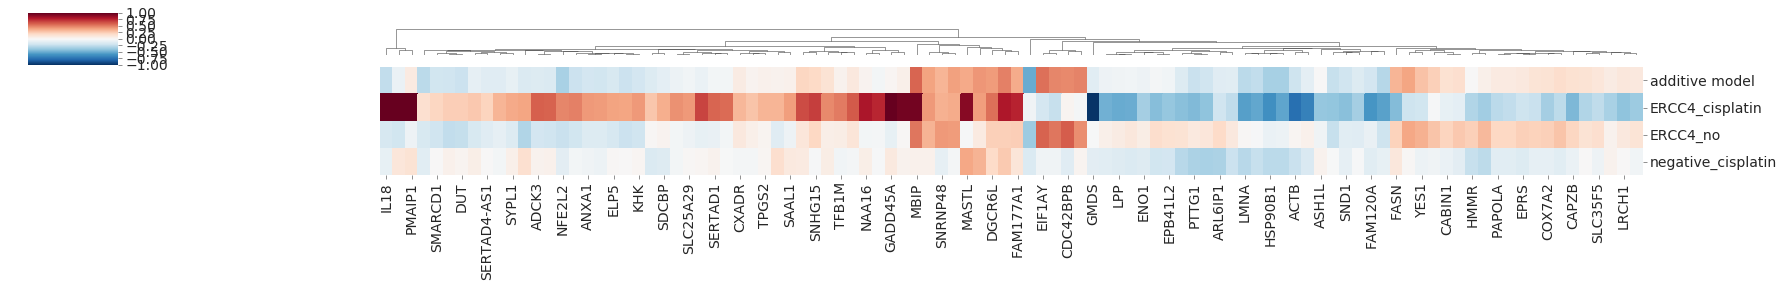

In [39]:
g = sns.clustermap(mean_subpop_tree.dropna(axis=1)[:-1], row_cluster=False, robust=True, cmap='RdBu_r', center=0, figsize=[25, 4], vmin=-1, vmax=1)
fig = g.fig

In [40]:
%%capture

gene = "ERCC4"
subpop = pop_i.subpopulation(cells='guide_target == "%s" | guide_target == "negative"' %(gene), normalized_matrix='inherit')
res = tree_selector(subpop,
                    key='long_experiment',
                    num_features=100,
                    genes='mean > 0.25',
                    normalized=True,
                    n_jobs=16)
tree_genes = res.selected_genes
mean_subpop = subpop.average('long_experiment')

mean_subpop_tree = mean_subpop.normalized_matrix.loc[:, tree_genes]

new_row = ts_preds.loc[gene+"_cisplatin", tree_genes] 
new_row.name = 'linear model'
mean_subpop_tree = pd.concat([pd.DataFrame(new_row).T, mean_subpop_tree])

mean_subpop_tree.columns = subpop.gene_names(mean_subpop_tree.columns)

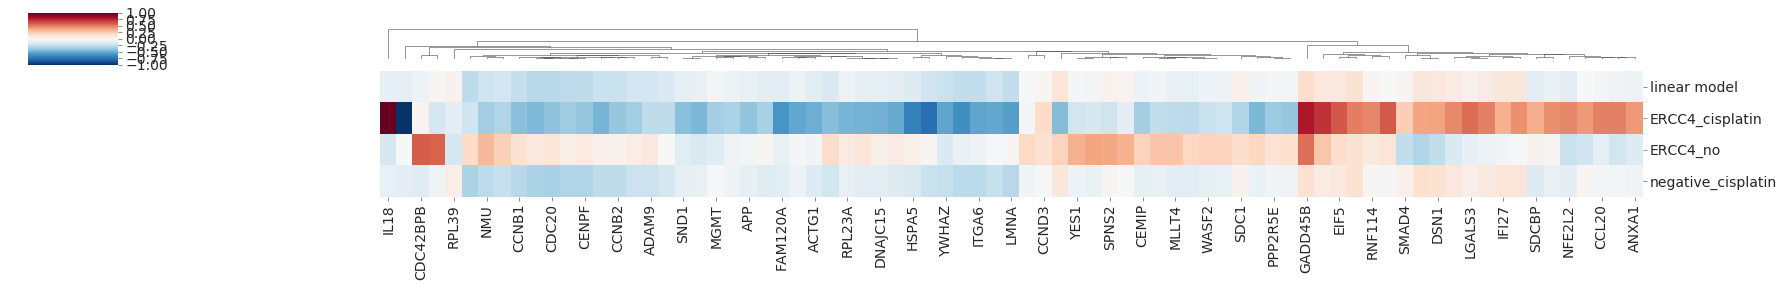

In [41]:
g = sns.clustermap(mean_subpop_tree.dropna(axis=1)[:-1], row_cluster=False, robust=True, cmap='RdBu_r', center=0, figsize=[25, 4], vmin=-1, vmax=1)
fig = g.fig

In [42]:
%%capture

gene = "ERCC6"
subpop = pop_i.subpopulation(cells='guide_target == "%s" | guide_target == "negative"' %(gene), normalized_matrix='inherit')
res = tree_selector(subpop,
                    key='long_experiment',
                    num_features=100,
                    genes='mean > 0.25',
                    normalized=True,
                    n_jobs=16)
tree_genes = res.selected_genes
mean_subpop = subpop.average('long_experiment')

mean_subpop_tree = mean_subpop.normalized_matrix.loc[:, tree_genes]

new_row = mean_subpop_tree.loc["negative_cisplatin"] + mean_subpop_tree.loc[gene+'_no']
new_row.name = 'additive model'
mean_subpop_tree = pd.concat([pd.DataFrame(new_row).T, mean_subpop_tree])

mean_subpop_tree.columns = subpop.gene_names(mean_subpop_tree.columns)

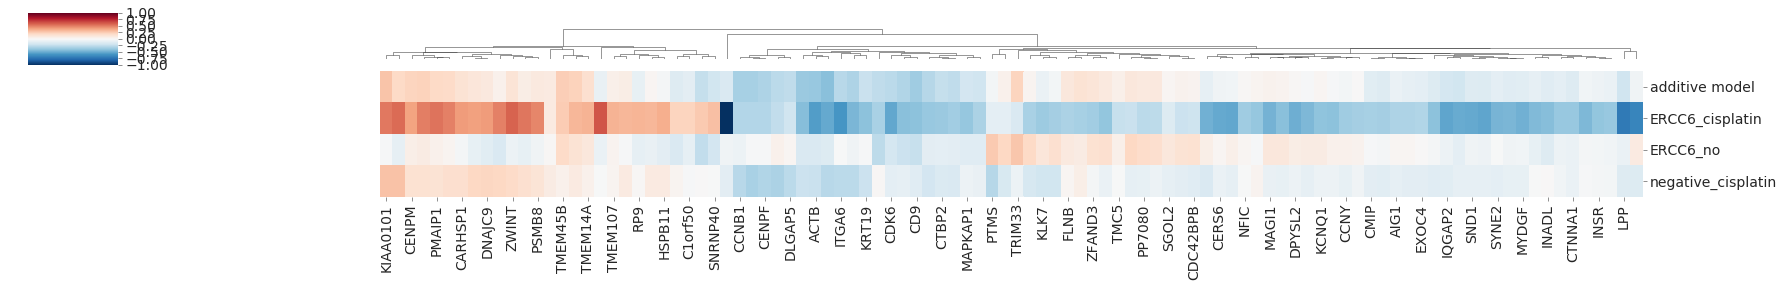

In [43]:
g = sns.clustermap(mean_subpop_tree.dropna(axis=1)[:-1], row_cluster=False, robust=True, cmap='RdBu_r', center=0, figsize=[25, 4], vmin=-1, vmax=1)
fig = g.fig

In [44]:
%%capture

gene = "ERCC6"
subpop = pop_i.subpopulation(cells='guide_target == "%s" | guide_target == "negative"' %(gene), normalized_matrix='inherit')
res = tree_selector(subpop,
                    key='long_experiment',
                    num_features=100,
                    genes='mean > 0.25',
                    normalized=True,
                    n_jobs=16)
tree_genes = res.selected_genes
mean_subpop = subpop.average('long_experiment')

mean_subpop_tree = mean_subpop.normalized_matrix.loc[:, tree_genes]

new_row = ts_preds.loc[gene+"_cisplatin", tree_genes] 
new_row.name = 'linear model'
mean_subpop_tree = pd.concat([pd.DataFrame(new_row).T, mean_subpop_tree])

mean_subpop_tree.columns = subpop.gene_names(mean_subpop_tree.columns)

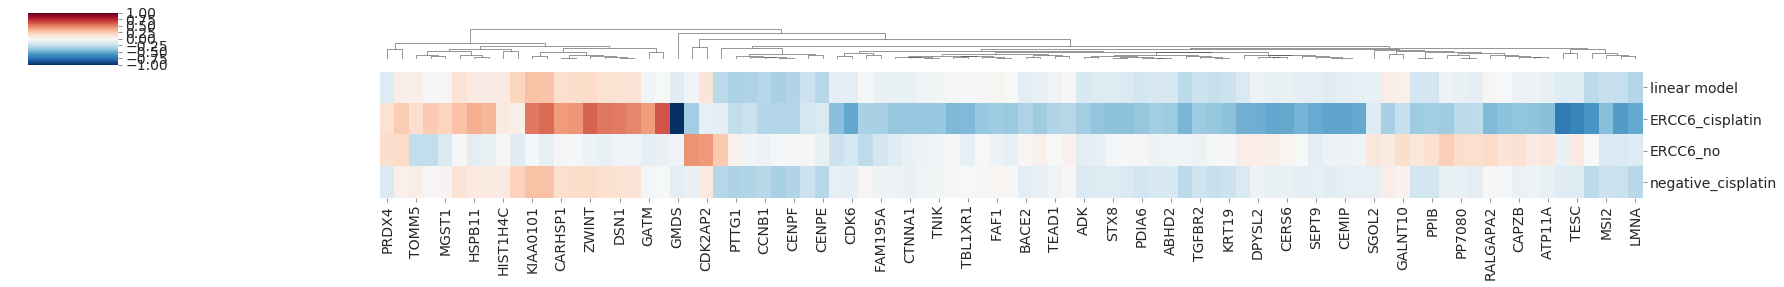

In [45]:
g = sns.clustermap(mean_subpop_tree.dropna(axis=1)[:-1], row_cluster=False, robust=True, cmap='RdBu_r', center=0, figsize=[25, 4], vmin=-1, vmax=1)
fig = g.fig


In [46]:
%%capture

gene = "ERCC8"
subpop = pop_i.subpopulation(cells='guide_target == "%s" | guide_target == "negative"' %(gene), normalized_matrix='inherit')
res = tree_selector(subpop,
                    key='long_experiment',
                    num_features=100,
                    genes='mean > 0.25',
                    normalized=True,
                    n_jobs=16)
tree_genes = res.selected_genes
mean_subpop = subpop.average('long_experiment')

mean_subpop_tree = mean_subpop.normalized_matrix.loc[:, tree_genes]

new_row = mean_subpop_tree.loc["negative_cisplatin"] + mean_subpop_tree.loc[gene+'_no']
new_row.name = 'additive model'
mean_subpop_tree = pd.concat([pd.DataFrame(new_row).T, mean_subpop_tree])

mean_subpop_tree.columns = subpop.gene_names(mean_subpop_tree.columns)


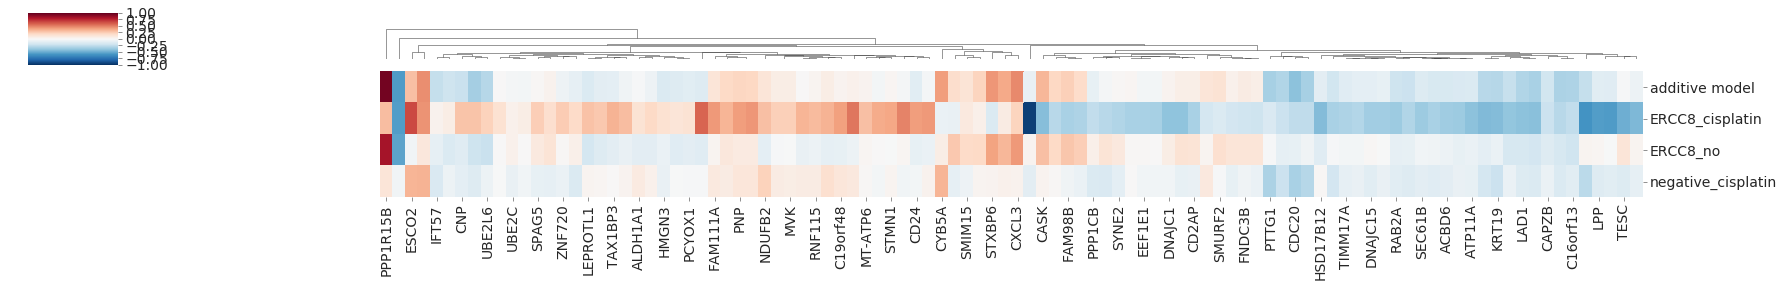

In [47]:
g = sns.clustermap(mean_subpop_tree.dropna(axis=1)[:-1], row_cluster=False, robust=True, cmap='RdBu_r', center=0, figsize=[25, 4], vmin=-1, vmax=1)
fig = g.fig

In [48]:
%%capture

gene = "ERCC8"
subpop = pop_i.subpopulation(cells='guide_target == "%s" | guide_target == "negative"' %(gene), normalized_matrix='inherit')
res = tree_selector(subpop,
                    key='long_experiment',
                    num_features=100,
                    genes='mean > 0.25',
                    normalized=True,
                    n_jobs=16)
tree_genes = res.selected_genes
mean_subpop = subpop.average('long_experiment')

mean_subpop_tree = mean_subpop.normalized_matrix.loc[:, tree_genes]

new_row = ts_preds.loc[gene+"_cisplatin", tree_genes] 
new_row.name = 'linear model'
mean_subpop_tree = pd.concat([pd.DataFrame(new_row).T, mean_subpop_tree])

mean_subpop_tree.columns = subpop.gene_names(mean_subpop_tree.columns)


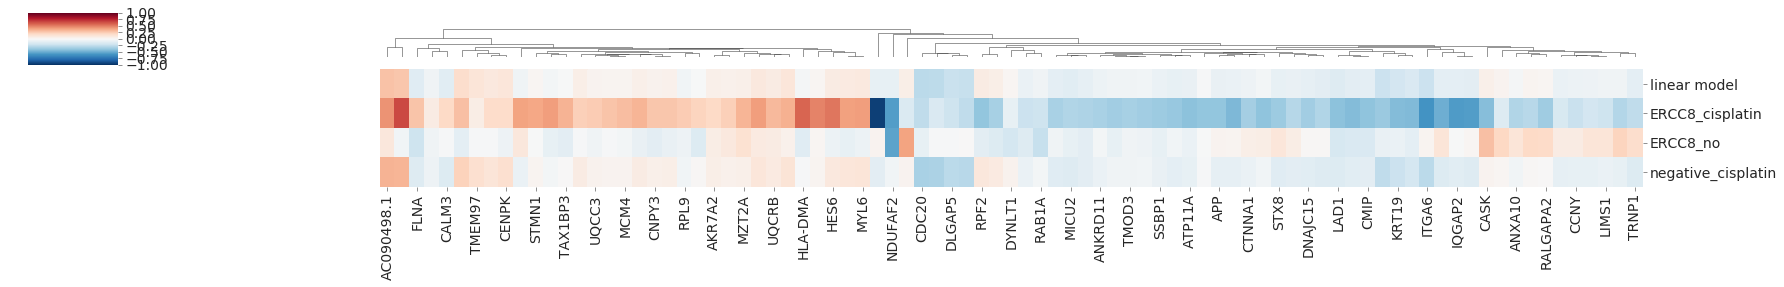

In [49]:
g = sns.clustermap(mean_subpop_tree.dropna(axis=1)[:-1], row_cluster=False, robust=True, cmap='RdBu_r', center=0, figsize=[25, 4], vmin=-1, vmax=1)
fig = g.fig